<a href="https://colab.research.google.com/github/VictorFu0717/AI/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

遷移學習:只有用後面的mlp,gap訓練
1.   偷VGG16
2.   接分類器

1.   訓練：cnn固定-->分類器調整

In [ ]:
import zipfile
path = "drive/MyDrive/train.zip "
f = zipfile.ZipFile(path)
f.extractall()
#解壓縮在同一層

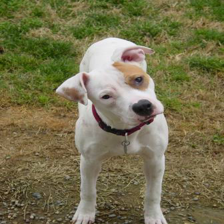

In [ ]:
#glob用來查找文件
import glob
from PIL import Image
fs = glob.glob("train/*")
Image.open(fs[666]).resize((224, 224)).convert("RGB")
#調整大小

In [ ]:

import pandas as pd
dog = glob.glob("train/dog.*")
cat = glob.glob("train/cat.*")
datas = pd.DataFrame({
        "path":dog + cat,
        "ans":[0] * len(dog) + [1] * len(cat)
})
datas

,path,ans
0,train/dog.4728.jpg,0
1,train/dog.5130.jpg,0
2,train/dog.10849.jpg,0
3,train/dog.1403.jpg,0
4,train/dog.10002.jpg,0
...,...,...
24995,train/cat.11146.jpg,1
24996,train/cat.6012.jpg,1
24997,train/cat.10002.jpg,1
24998,train/cat.1799.jpg,1


In [ ]:
# 在keras appliation偷模型
# include_top要不要當初的mlp
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
vgg_layers = vgg.layers
#trainable：vgg不用來訓練，只用後面的mlp來訓練
for l in vgg_layers:
    l.trainable = False
#準備mlp的layer
clf_layers = [
    #flatten讓他展開成一維
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.25),
    Dense(2, activation="softmax")
]
model = Sequential(vgg_layers + clf_layers)
model.summary()
#這裡的dense的參數要選少，因為資料集不多

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(), 
       optimizer="adam",
       metrics=["accuracy"])

In [ ]:
# demo pre: 你的預處理也要抄當初的預處理,這裡不可以除以255,因為當初的vgg16不是用tensorflow
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fs[5000]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

array([[[ 41.060997 ,  22.221    ,   8.32     ],
        [ 39.060997 ,  20.221    ,   6.3199997],
        [ 43.060997 ,  24.221    ,  10.32     ],
        ...,
        [-20.939003 , -32.779    , -41.68     ],
        [-23.939003 , -35.779    , -44.68     ],
        [-25.939003 , -37.779    , -46.68     ]],

       [[ 39.060997 ,  20.221    ,   6.3199997],
        [ 37.060997 ,  18.221    ,   4.3199997],
        [ 41.060997 ,  22.221    ,   8.32     ],
        ...,
        [-20.939003 , -32.779    , -41.68     ],
        [-22.939003 , -34.779    , -43.68     ],
        [-24.939003 , -36.779    , -45.68     ]],

       [[ 34.060997 ,  15.221001 ,   1.3199997],
        [ 33.060997 ,  14.221001 ,   0.3199997],
        [ 37.060997 ,  18.221    ,   4.3199997],
        ...,
        [-19.939003 , -31.779    , -41.68     ],
        [-20.939003 , -32.779    , -41.68     ],
        [-22.939003 , -34.779    , -43.68     ]],

       ...,

       [[ 17.060997 ,   1.2210007,   3.3199997],
        [ 1

In [ ]:
x, y = np.array(datas["path"]), np.array(datas["ans"])

In [ ]:
#batch多少張調整一次梯度下降
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    y_batch = y[idx]
    x_batch, x_batch_ori = [], []
    for p in x[idx]:
        img = Image.open(p).resize((224, 224)).convert("RGB")
        img_np = np.array(img) 
        img_np_pre = preprocess_input(img_np)
        x_batch.append(img_np_pre)
        x_batch_ori.append(img_np)
    return (np.array(x_batch), np.array(y_batch), np.array(x_batch_ori))
x_batch, y_batch, x_batch_ori = get_data(x, y)
print(x_batch.shape)
print(y_batch.shape)
print(x_batch_ori.shape)

(20, 224, 224, 3)
(20,)
(20, 224, 224, 3)


In [ ]:
for i in range(20):
    print("-" * 15, i, "-" * 15)
    x_batch, y_batch, x_batch_ori = get_data(x, y)
    result = model.train_on_batch(x_batch, y_batch)
    print("[Train]:", result)
    x_batch, y_batch, x_batch_ori = get_data(x, y)
    result = model.test_on_batch(x_batch, y_batch)
    print("[Validate]:", result)

--------------- 0 ---------------
[Train]: [16.029020309448242, 0.5]
[Validate]: [43.826271057128906, 0.800000011920929]
--------------- 1 ---------------
[Train]: [84.947265625, 0.6499999761581421]
[Validate]: [59.206573486328125, 0.44999998807907104]
--------------- 2 ---------------
[Train]: [33.3289794921875, 0.6000000238418579]
[Validate]: [2.4163687229156494, 0.800000011920929]
--------------- 3 ---------------
[Train]: [3.265775203704834, 0.800000011920929]
[Validate]: [6.398298263549805, 0.8999999761581421]
--------------- 4 ---------------
[Train]: [7.593743324279785, 0.8500000238418579]
[Validate]: [4.776307106018066, 0.8500000238418579]
--------------- 5 ---------------
[Train]: [6.211116313934326, 0.8500000238418579]
[Validate]: [4.631529331207275, 0.8999999761581421]
--------------- 6 ---------------
[Train]: [0.043931085616350174, 0.949999988079071]
[Validate]: [4.7087468146855826e-07, 1.0]
--------------- 7 ---------------
[Train]: [1.2504045963287354, 0.949999988079071]

In [ ]:
model.predict(x_batch)

array([[1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [5.43131675e-13, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.99987245e-01, 1.27470985e-05],
       [1.00000000e+00, 0.00000000e+00],
       [4.28758901e-34, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [3.57955319e-15, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [4.51908454e-06, 9.99995470e-01]], dtype=float32)

In [ ]:
x_batch, y_batch, x_batch_ori = get_data(x, y, 2000)
model.evaluate(x_batch, y_batch)

63/63 [==============================] - 14s 178ms/step - loss: 1.9149 - accuracy: 0.9425


[1.9148942232131958, 0.9424999952316284]

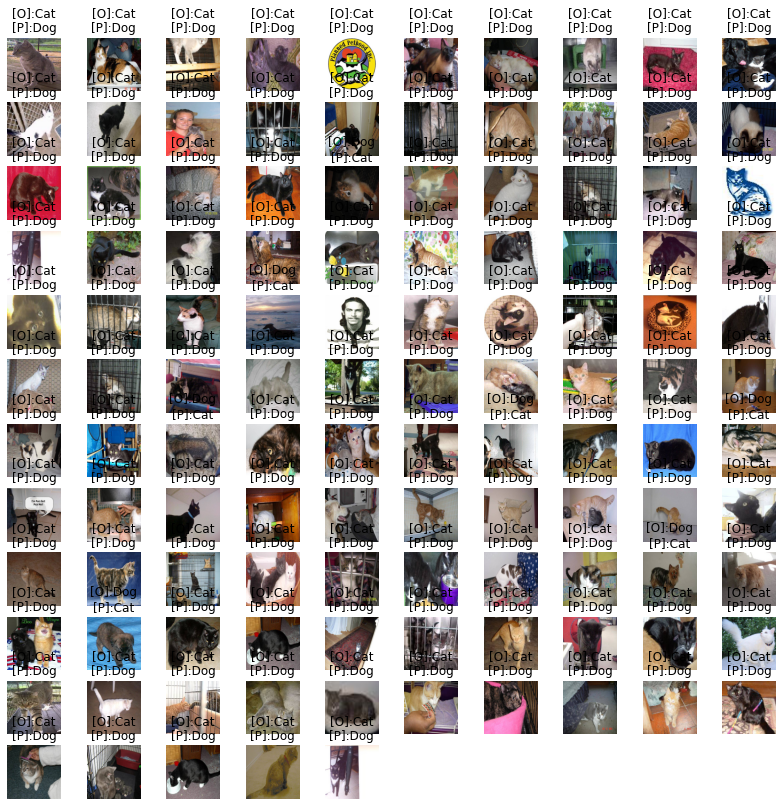

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#pre = model.predict_classes(x_batch) #tensorflow 撤銷此指令，改為下列這行
pre = np.argmax(model.predict(x_batch), axis=-1)
trans = ["Dog", "Cat"]
idx = np.nonzero(pre != y_batch)[0][:200]
false_img = x_batch_ori[idx]
false_pre = pre[idx]
false_label = y_batch[idx]
plt.figure(figsize=(14, 14))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[false_label[i]], trans[false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(false_img[i])

url:https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*
Dog 的機率: 1.0
Cat 的機率: 0.0
答案: Dog


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


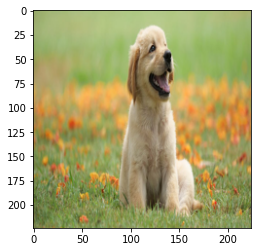

In [ ]:
# Pillow
import requests
from PIL import Image
# RGB, RGBA, L(gray)
url = input("url:")
headers = {
  "user-agent":"user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36"  
}
response = requests.get(url, headers=headers, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_r = preprocess_input(img_np.reshape(1, 224, 224, 3))
proba = model.predict(img_np_r)[0]
for i, p in enumerate(proba):
    print(trans[i], "的機率:", p)
#ans = model.predict_classes(img_np_r)[0]
ans = np.argmax(model.predict(img_np_r), axis=-1)[0]
print("答案:", trans[ans])
plt.imshow(img_np)